Import Liblary

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

Membaca data file CSV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/praktikum_ml/praktikum04/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


Melihat informasi umum dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


Data Pre-pocessing

In [5]:
# cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [6]:
df.duplicated().sum()

np.int64(7308)

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
# cek nilai unik
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [10]:
# cek nilai unik
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [11]:
# mapping kolom kategorik ke bentuk numerik

# 1. mapping kolom stunting -> biner
map_stunt = {'Stunted': 1, 'Sevely Stunted': 1, 'Normal': 0, 'Tall': 0 }
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. mapping kolom jenis kelamin -> biner
# Laki-laki = 1, perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    15039
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


In [12]:
# analisis korelasi antar variabel numerik

corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.060457,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.228848,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.036985,0.043446
Stunting_bin,0.060457,-0.228848,0.036985,1.000000,-0.008803
JK_bin,0.000636,0.070159,0.043446,-0.008803,1.000000


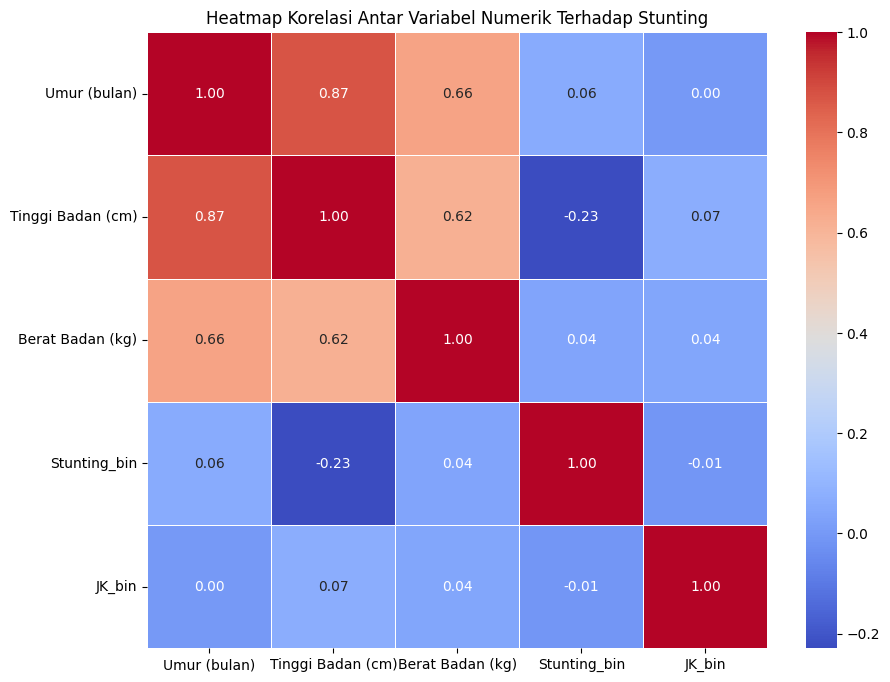

In [13]:
# Visualisasi heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik Terhadap Stunting", fontsize=12)
plt.show()

Pembagian dataset (Training dan Testing)

In [14]:
# Menentukan fitur dan target
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (87359, 4)
y shape: (87359,)


In [15]:
# membagi dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (69887, 4)
Data uji: (17472, 4)


pembangunan model logistic regression

In [16]:
# scale hanya fitur numerik, gender langsung passthrough
prepocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('prepocessing', prepocess),
    ('model', model)
])

# latihan model
clf.fit(X_train, y_train)
print("✅ Model logistic regression berhasil dilatih.")

✅ Model logistic regression berhasil dilatih.


Prediksi model dan evaluasi model

In [17]:
# prediksi dan probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision   : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall      : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 - Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC - AUC   : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi     : 0.8945
Precision   : 0.6268
Recall      : 0.9574
F1 - Score  : 0.7576
ROC - AUC   : 0.9585


visualisasi hasil evaluasi

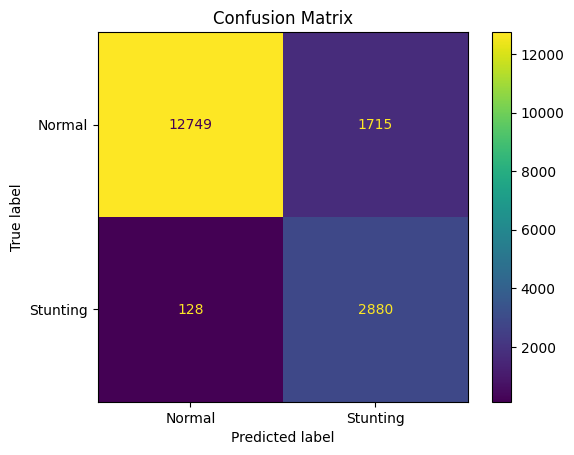

In [18]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                       ).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()



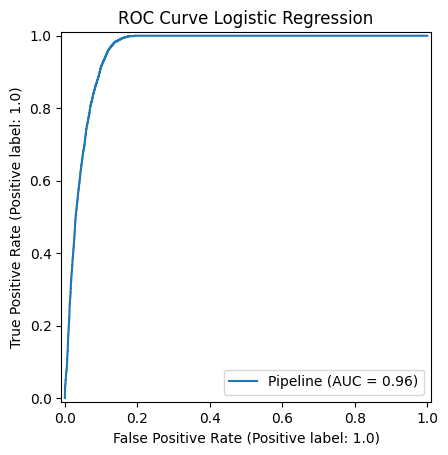

In [19]:
# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

Classification report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stuting (0)', 'Stuting (1)']))

                   precision    recall  f1-score   support

Tidak Stuting (0)       0.99      0.88      0.93     14464
      Stuting (1)       0.63      0.96      0.76      3008

         accuracy                           0.89     17472
        macro avg       0.81      0.92      0.85     17472
     weighted avg       0.93      0.89      0.90     17472



In [21]:
from sklearn.model_selection import cross_val_score
# lakukan cross validation (cv=5 berarti 5-fold
scores = cross_val_score(clf, X, y, cv=5)

# tampilkan hasil
print("Kkor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))
#

Kkor tiap fold: [0.89789377 0.89188416 0.89434524 0.89634844 0.89187797]
Rata-rata akurasi: 0.8944699161855449
Standar deviasi: 0.002394641530312821


interprestasi model logistic regression

In [22]:
# ambil nama fitur dan koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'fitur': feat_names,
    'koefisien (log-odds)': coefs,
    'odds ratio (e^coef)': odds
}).sort_values('odds ratio (e^coef)', ascending=False)

display(coef_df)

,fitur,koefisien (log-odds),odds ratio (e^coef)
0,Umur (bulan),8.497195,4901.000691
3,JK_bin,1.675246,5.340108
2,Berat Badan (kg),0.636468,1.889794
1,Tinggi Badan (cm),-10.434187,0.000029


prediksi data baru

In [23]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0] # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998440,1.0
1,10,72.5,7.8,0,0.002482,0.0


praktikum mandiri 4

In [24]:
df = pd.read_csv("/content/drive/MyDrive/praktikum_ml/praktikum04/data/calonpembelimobil.csv")
df.head()

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [28]:
# melihat apakah ada missing value
df.isna().sum()

,0
ID,0
Usia,0
Status,0
Kelamin,0
Memiliki_Mobil,0
Penghasilan,0
Beli_Mobil,0


In [29]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
ID,1.000000,0.149779,-0.006634,0.014646,0.068555,0.254177,0.168614
Usia,0.149779,1.000000,0.051476,0.019454,0.090926,0.125859,0.100127
Status,-0.006634,0.051476,1.000000,-0.008561,0.048302,0.071714,0.048584
Kelamin,0.014646,0.019454,-0.008561,1.000000,0.035199,-0.054211,-0.147301
Memiliki_Mobil,0.068555,0.090926,0.048302,0.035199,1.000000,0.137823,0.102005
Penghasilan,0.254177,0.125859,0.071714,-0.054211,0.137823,1.000000,0.763930
Beli_Mobil,0.168614,0.100127,0.048584,-0.147301,0.102005,0.763930,1.000000


heatmap

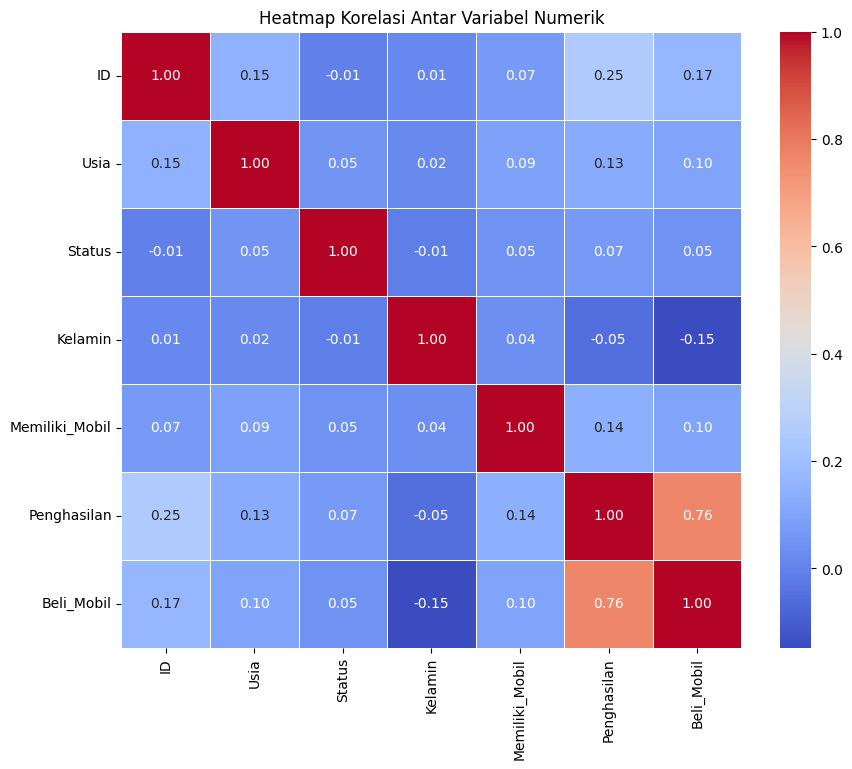

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik", fontsize=12)
plt.show()

In [38]:
feature_num = ['Usia', 'Status', 'Kelamin', 'Memiliki_Mobil']
feature_bin = ['Penghasilan']

use_cols = feature_num + feature_bin + ['Beli_Mobil']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Beli_Mobil']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 5)
y shape: (1000,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (800, 5)
Data uji: (200, 5)


In [40]:
prepocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('prepocessing', prepocess),
    ('model', model)
])

# latihan model
clf.fit(X_train, y_train)
print("✅ Model logistic regression berhasil dilatih.")

✅ Model logistic regression berhasil dilatih.


In [41]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# menghitung metrik
print(f"Akurasi     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision   : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score    : {f1_score (y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC     : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi     : 0.9300
Precision   : 0.9748
F1-Score    : 0.9431
ROC-AUC     : 0.9770


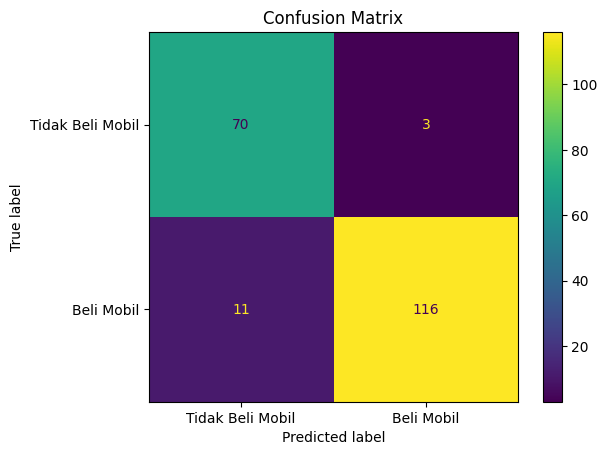

In [42]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Tidak Beli Mobil', 'Beli Mobil']
                       ).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()

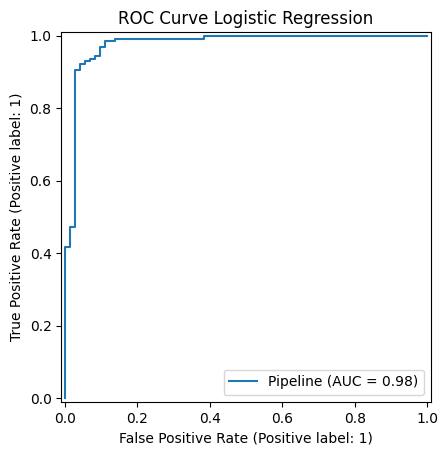

In [43]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Beli Mobil', 'Beli Mobil']))


                  precision    recall  f1-score   support

Tidak Beli Mobil       0.86      0.96      0.91        73
      Beli Mobil       0.97      0.91      0.94       127

        accuracy                           0.93       200
       macro avg       0.92      0.94      0.93       200
    weighted avg       0.93      0.93      0.93       200



In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)

print("Skor setiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))


Skor setiap fold: [0.785 0.91  0.955 0.945 0.94 ]
Rata-rata akurasi: 0.907
Standar deviasi: 0.06281719509815761


In [51]:
feat_names = feature_num + feature_bin
coefss = clf.named_steps['model'].coef_[0]
odds = np.exp(coefss)

coef_df = pd.DataFrame({
    'fitur': feat_names,
    'koefisien (log-odds)': coefss,
    'odds ratio (e^coef)': odds
}).sort_values('odds ratio (e^coef)', ascending=False)

display(coef_df)

,fitur,koefisien (log-odds),odds ratio (e^coef)
3,Memiliki_Mobil,0.083176,1.086733
4,Penghasilan,0.055951,1.057546
0,Usia,-0.082246,0.921045
1,Status,-0.168034,0.845325
2,Kelamin,-0.655173,0.519352


In [53]:
data_baru = pd.DataFrame({
    'Usia'            :[25, 30],
    'Status'          :[1, 0],
    'Kelamin'         :[1, 0],
    'Memiliki_Mobil'  :[2, 0],
    'Penghasilan'     :[700, 65]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Beli_Mobil'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_Beli_Mobil,"Pred (0=Tidak,1=Ya)"
0,25,1,1,2,700,1.000000,1
1,30,0,0,0,65,0.000235,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!git config --global user.email "jamilatunnisa996@gmail.com"
!git config --global user.name "Jamilatun Khoerunnisa"

!git clone https://github.com/Jamilatun/ti03_Mila_01101222254.git
%cd ti03_Mila_01101222254

!cp -r /content/drive/MyDrive/praktikum_ml/praktikum04 ./praktikum04

!ls -lah

!git add .
!git commit -m "Upload folder praktikum02 dari Colab"

from getpass import getpass
import os

token = getpass("Masukkan GitHub Token: ")

os.system(f'git remote set-url origin https://{token}@github.com/Jamilatun/ti03_Mila_01101222254.git')

!git push origin main